In [26]:
#import jax.numpy as jnp
import numpy as jnp
import matplotlib.pyplot as plt



## Spectral method 
x_lb = 0 
x_rb = 1
d = 2
n = 6
N_x =2**n


In [27]:
L = x_rb - x_lb
dx = L/N_x
y_lb = x_lb
y_ub = x_rb
N_y = N_x
xs, ys = jnp.meshgrid(jnp.linspace(x_lb, x_rb, N_x, endpoint=False), 
                    jnp.linspace(y_lb, y_ub, N_y, endpoint=False), 
                    indexing='ij')

In [28]:
# classical 
def f(x, y) : 
    return jnp.cos(2*jnp.pi *x) * jnp.sin(-4*jnp.pi * y)

# Poissons's equation
#A = jnp.eye(d)
#u_theo = f(xs, ys)*(-1/(20*jnp.pi**2))

# elliptic with constant coefficient for d = 2
A = jnp.array(
    [
        [3., 1.], 
        [1., 2.]
    ]
)

#u_theo = u_true(xs, ys)

In [29]:
# classical spectral method
def Elliptic_fft(u, N_x, N_y, dx, A=A): 
    u_h = jnp.fft.rfft2(u)
    wave = jnp.fft.fftfreq(N_x, d= dx) * 2j* jnp.pi
    wave_real = jnp.fft.rfftfreq(N_y, d= dx)* 2j* jnp.pi
    k_x, k_y = jnp.meshgrid(wave, wave_real, indexing='ij')

    u_x_h =  k_x * u_h
    u_xx_h = k_x * u_x_h
    u_yx_h =  k_y * u_x_h
    u_y_h =  k_y * u_h
    u_xy_h =  k_x * u_y_h
    u_yy_h = k_y * u_y_h

    u_xx = jnp.fft.irfft2(u_xx_h, s=(N_x, N_y))
    u_xy = jnp.fft.irfft2(u_xy_h, s=(N_x, N_y))
    u_yy = jnp.fft.irfft2(u_yy_h, s=(N_x, N_y))
    u_yx = jnp.fft.irfft2(u_yx_h, s=(N_x, N_y))

    return A[0, 0] * u_xx + A[0, 1] * u_xy + A[1, 0] * u_yx + A[1, 1] * u_yy

In [30]:

"""Constructs the 1D DFT matrix of size N."""
dfmtx = jnp.fft.fft(jnp.eye(N_x))#/jnp.sqrt(N_x)

"""Constructs the 2D DFT matrix of size N x N as a Kronecker product."""
FG = jnp.kron(dfmtx, dfmtx)
GF = jnp.kron(
    (jnp.conj(dfmtx).T)/N_x, 
    (jnp.conj(dfmtx).T)/N_x, 
)

In [31]:
def spectral_eigenvalues(N, L=1.0):
    """Eigenvalues of the 1D derivative operator with periodic condition."""
    k = jnp.fft.fftfreq(N, d=L/N) * 2j * jnp.pi  # frequency vector
    return k  


In [32]:
    
def solver_Elliptic(f, A=A): 
    f_values = f(xs, ys)

    f_h = jnp.fft.fft2(f_values)
    wave = jnp.fft.fftfreq(N_x, d= dx) * 2j* jnp.pi
    wave[0] = 1
    wave_real = jnp.fft.fftfreq(N_y, d= dx)* 2j* jnp.pi
    wave_real[0] = 1
    k_x, k_y = jnp.meshgrid(wave, wave_real, indexing='ij')
    

    u_h = f_h/ (A[0,0]*k_x**2 + + A[1, 0]* k_x * k_y + A[0, 1] * k_y *k_x + A[1,1]*k_y**2)

    return jnp.fft.ifft2(u_h, s= (N_x, N_y))

# Kron
def solver_Elliptic_FG(f, A=A): 

    # Fourier transform
    f_flatten = f(xs, ys).flatten()
    f_h = FG @ f_flatten

    # Build laplacian in spectral domain
    D = jnp.diag( 
        spectral_eigenvalues(N_x)
    )
    

    Elliptic_spec = A[0,0]*jnp.kron(D**2, jnp.eye(N_x)) + A[0, 1] * jnp.kron(D, D) + A[1, 0] * jnp.kron(D, D) + A[1, 1]*jnp.kron(jnp.eye(N_x), D**2)

    Elliptic_spec[0, 0] = 1 # avoid zero inversion
    inverse_Elliptic = jnp.linalg.inv(Elliptic_spec)


    # Apply Laplacian in spectral domain and Inverse FFT
    u_flatten = GF @ inverse_Elliptic @ f_h

    return u_flatten.reshape(N_x, N_x)

u_spec = solver_Elliptic_FG(f)
u_theo = solver_Elliptic(f)


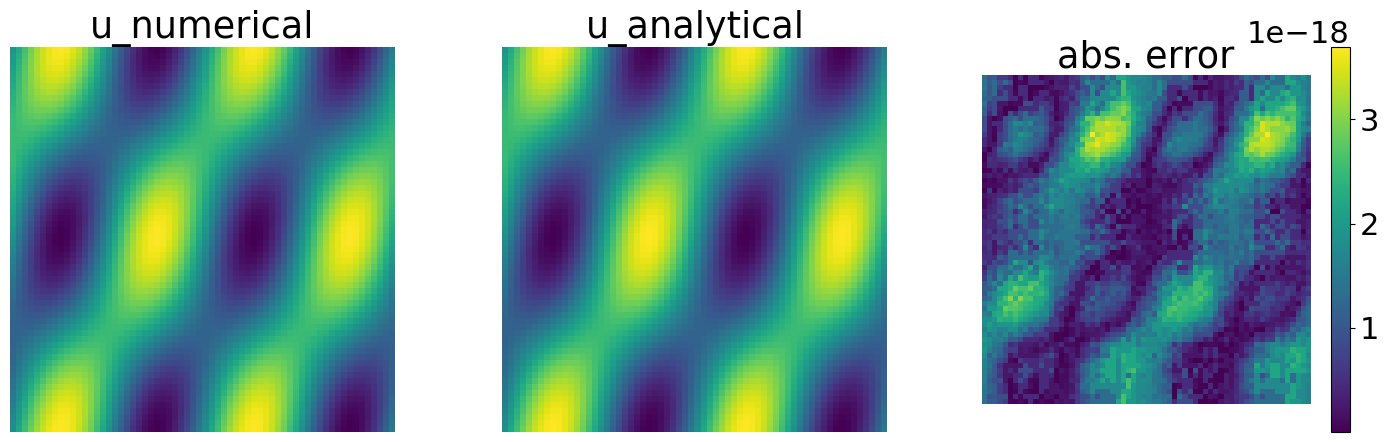

In [ ]:
plt.figure(figsize=(18, 5))
plt.rcParams.update({'font.size': 22})
plt.subplot(1, 3, 1)
plt.imshow(u_theo.real, extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.axis('off')
plt.title("u_numerical")
plt.subplot(1, 3, 2)
plt.imshow(u_spec.real, extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.axis('off')
plt.title("u_analytical")
plt.subplot(1, 3, 3)
plt.imshow(abs(u_spec-u_theo), extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("abs. error")
plt.colorbar()
plt.axis('off')
#plt.savefig("Poisson2D_num.png", bbox_inches='tight')
#plt.savefig("Elliptic2D_num.png", bbox_inches='tight')



In [34]:
#normalized_u_spec = u_spec / jnp.linalg.norm(u_spec)
#normalized_u_theo = u_theo/ jnp.linalg.norm(u_theo)
error = jnp.linalg.norm(u_spec - u_theo)/jnp.linalg.norm(u_theo)
error

9.433814779164908e-16